## 分析A/B测试结果

这个项目可以帮你确认你已经掌握了统计课程中涵盖的所有内容。 希望这个项目尽可能地涵盖所有内容。 祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通常情况下，A/B 测试由数据分析师和数据科学家来完成。如果你在一些实践工作中遇到过这方面的问题，那学习起来就会更加游刃有余。

对于这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。你的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**使用该 notebook 的时候，请同步学习课堂内容，并回答与每个问题相关的对应测试题目。** 每个课堂概念的标签对应每个题目。这样可以确保你在完成项目的过程中的方法正确，并且你最终提交的内容会更加符合标准，不必担心出现错误。最后检查的时候，请确保你的提交内容符合 [审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 中的所有标准。

<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始你的任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [4]:
df.user_id.nunique()

290584

d. 用户转化的比例。

In [5]:
df['converted'].mean()

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
((df['group']=="treatment") & (df['landing_page']=="old_page")).sum()+ ((df['group']=="control") & (df['landing_page']=="new_page")).sum()

#或者也可以用如下代码，仅作为记录
#df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]['user_id'].count()

3893


f. 是否有任何行存在缺失值？

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

由上可见，数据集不存在缺失值。

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
#查找数据集中treatment不与 new_page一致的行或control不与old_page一致的行，并打印信息查看
df1 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 22 to 294331
Data columns (total 5 columns):
user_id         3893 non-null int64
timestamp       3893 non-null object
group           3893 non-null object
landing_page    3893 non-null object
converted       3893 non-null int64
dtypes: int64(2), object(3)
memory usage: 136.9+ KB


由上可见，共找到3893行不一致的行。以下需进行删除。

In [9]:
#删除不符合要求的行，并将删除后的新数据集存在df2中
df2=df.drop(index = df1.index)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 10.0+ MB


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

由上可见，所有reatment不与 new_page一致的行或control不与 old_page一致的行，已经被删除掉了。

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [11]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [12]:
#查找重复的user_id的个数
df2.user_id.duplicated().sum()

1

In [13]:
#定位到有重复user_id的行
df2.loc[df2.user_id.duplicated()==1]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

In [14]:
#查看有重复user_id的行信息
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [15]:
#删除其中一行有重复user_id的行
df2 = df2.drop(index = 2893)
#查看行数是否减少了一行
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 10.0+ MB


In [16]:
#再次查看该user_id，确保已经被删除
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [17]:
#单个用户的转化率
df2['converted'].mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [18]:
p_old= df2[df2['group'] == "control"]['converted'].mean()
p_old

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [19]:
p_new = df2[df2['group'] == "treatment"]['converted'].mean()
p_new

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [20]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

**在这里写出你的答案。**

In [21]:
obs_diff = p_new - p_old
obs_diff

-0.0015782389853555567

以上为数据集中experiment组（即new_page组）和control组（即old_page组）的转化率之差，两者相差并不大，并且与单用户的总转化率的0.1196接近。因此，根据目前的观察，没有证据能证明某个页面能带来更多的转化。

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

**在这里给出你的答案。**

零假设$$H_0：P_{new}-P_{old}\leq0$$

备择假设$$H_1：P_{new}-P_{old}>0$$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

使用下面的单元格提供这个模拟的必要内容。如果现在还没有完整的意义，不要担心，你将通过下面的问题来解决这个问题。你可以通过做课堂中的 **测试 5** 来确认你掌握了这部分内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


对于零假设来说，既然已经假设了$p_{new}$与$p_{old}$是相等的，且都等于ab_data.csv中的转化率，新旧页面都是如此。 则以下$p_{new}$与$p_{old}$计算如下：

In [22]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [23]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [24]:
#计算新页面的样本大小
n_new = df2[df2['group'] == "treatment"].shape[0]
n_new

145310

d.  $n_{old}$?是多少？

In [25]:
#计算旧页面的样本大小
n_old = df2[df2['group'] == "control"].shape[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [26]:
new_page_converted = np.random.choice(np.arange(2),n_new,p=[(1-p_new),p_new])
new_page_converted

array([1, 0, 0, ..., 0, 0, 1])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [27]:
old_page_converted = np.random.choice(np.arange(2),n_old,p=[(1-p_old),p_old])
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0007180602930958041

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(np.arange(2),n_new,p=[(1-p_new),p_new])
    old_page_converted = np.random.choice(np.arange(2),n_old,p=[(1-p_old),p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
#这段代码略耗时

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？通过回答课堂上的匹配问题，确保你完全理解这里计算出的内容。

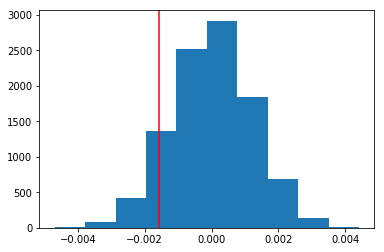

In [30]:
p_diffs = np.array(p_diffs)

#对新的模拟矩阵画直方图
plt.hist(p_diffs)
#画观测样本检测的差异值，为红线
plt.axvline(x=obs_diff,color='red')

正如预期，直方图基本以x=0的中心，呈现标准正态分布。而样本检测到的差异值，与模拟的差异值，相差数值很小。

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [31]:
(p_diffs > obs_diff).mean()

0.9054

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

**在这里给出你的答案。**


从以上j的分析，模拟样本中的模拟差异值，大于检测样本的观测差异值，所占的比例有90.54%。也就是说，在零假设的条件下，模拟差异值大于观测差异值的概率为90.54%，即上方直方图中红线以上的部分。

而在科学研究中，这个值是当零假设为$H_0：P_{new}-P_{old}\leq0$的p-value。

由于p-value远大于type I error的错误率$\alpha=0.05$，不具备统计显著性。因此，我们不能拒绝原零假设，即不能排除旧页面的转化率好于新页面的转化率的可能性。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [32]:
import statsmodels.api as sm
  
convert_old = df2[df2['group'] == "control"]['converted'].sum()
convert_new = df2[df2['group'] == "treatment"]['converted'].sum()
n_old = df2[df2['group']=='control'].shape[0]
n_new = df2[df2['group']=='treatment'].shape[0]
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [1]:
from scipy.stats import norm
#计算上测检测，z的临界值
norm.ppf(1-0.05)

1.6448536269514722

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

**在这里给出你的答案。**

根据内置程序的计算结果，z-score为-1.31，p-value为0.9051。这个p-value跟在第j.步骤中模拟出来的0.9054非常接近。

而根据以上得到的z_score = -1.31,远小于$\alpha = 0.05$时对应的z的临界值1.64，故无法拒绝$H_0$；

或者，p-value = 0.9051，远大于$\alpha$, 因此也不能拒绝$H_0$。即不能排除旧页面的转化率好于新页面的转化率的可能性。

这个判断跟在**j.k.**步骤中所得结果一致。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

应该采用逻辑回归 logistic regression

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [35]:
#添加新的ab_page列和截距列，并查看是否添加正确
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis=1)
df2.rename(columns = {'treatment':'ab_page'},inplace=True)
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [36]:
#用converted_列做应变量，截距列和ab_page列做自变量，进行逻辑回归
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:19:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [37]:
1/np.exp(-0.0150)

1.015113064615719

以上模型回归结果中，我们重点提取ab_page的回归系数-0.0150,和ab_page的p-value为0.190。根据ab_page的回归系数，可以解释成：在假设其它变量不变的情况下，当ab_page的结果从1降为0，转化值为之前的1.015倍。可见这个变化并不大。

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

与ab_page关联的p-value是0.19。在回归模型中，对于ab_page相关系数的零假设和备择假设分别为$$H_0:\beta_1 = 0$$$$H_1:\beta_1\not=0$$当p_value=0.19时，远大于$\alpha=0.05$的要求，因此我们不能拒绝零假设，即无法排除$\beta_1=0$的可能。也就是说，不能排除A/B两种检验方式，和页面转化不具有相关性的可能。

Part II中的零假设和备择假设分别为：$$H_0：P_{new}-P_{old}\leq0$$$$H_1：P_{new}-P_{old}>0$$Part II得到的p-value为0.9061，因此不能拒绝原零假设，即不能判定新旧页面的转化率二者之间存在区别。

两个p-value值不同的原因，就在于两者的做的假设不同，从而导致所做检验不同。第III部分回归模型中所做的是双尾检测，而第II部分中，做的是单尾检测。从双卫检测的p值，可以通过1-0.19/2=0.9050，得出相应的单尾检测的p值，这个值与第II部分的值基本吻合。



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

现实情况中，可能影响到页面转化率的因素比较多，因此有必要考虑其他因素。理论上，加入更多的考虑因素到回归模型中，会使相关系数$R^2$提高，并降低MSE。因此有必要考虑其他因素到回归模型中。

在回归模型中添加附加项的弊端主要是：加入附加项，尤其是高阶项之后，在解释模型和统计摘要时，会非常复杂。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [38]:
#导入countries.csv数据集，存入df4，并查看基本信息
df4=pd.read_csv('countries.csv')
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [39]:
#将经过整理的df2和新导入的df4，合并并查看
df3 = pd.merge(df2, df4, on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [40]:
#查看country列中的数值，为提取dummy variables做准备
df3['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [41]:
#从country列提取dummy variables，只保留CA和UK列
df3[['CA','UK','US']]= pd.get_dummies(df3['country'])
df3 = df3.drop('US',axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0


In [42]:
#针对新加入的国家列，进行逻辑回归
logit_mod = sm.Logit(df3['converted'],df3[['intercept','CA','UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        00:20:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [43]:
np.exp(-0.0408),np.exp(0.0099)

(0.9600211149716509, 1.0099491671175422)

CA和UK列的拟合系数分别为1.042和1.010。解读为当CA和UK从0变化到1时，转化率分别为原来的0.96倍和1.042倍。基本变化不大。

CA和UK列的p-value分别为0.129和0.456，远大于0.025的标准，因此均不能排除$H_0:\beta_1 = 0$的零假设。即国家列和转化率存在不相关的可能性。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [44]:
#为了查看new_page和国家之间的相互左右，需加入new_page和国家之间的交互项
#创建new_page列
df3[['new_page','old_page']]= pd.get_dummies(df3['ab_page'])
df3 = df3.drop('old_page',axis=1)
#加入new_page和国家之间交互项的两列
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,new_page,new_CA,new_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [45]:
#加入了交互项之后的逻辑回归，所有与交互项相关联的低阶项，也必须加入自变量
logit_mod = sm.Logit(df3['converted'],df3[['intercept','new_page','CA','UK','new_CA','new_UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        00:20:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0070      0.010   -207.045      0.000      -2.026      -1.988
new_page       0.0206      0.014      1.505      0.132      -0.006       0.047
CA            -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK             0.0257      0.019      1.363      0.173      -0.011       0.063
new_CA         0.0469      0.054      0.872      0.383      -0.059       0.152
new_UK        -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [47]:
np.exp(0.0206),np.exp(-0.0644),np.exp(0.0257),np.exp(0.0469),np.exp(-0.0314)

(1.020813644503746,
 0.9376298725613128,
 1.0260330923696246,
 1.0480172021191831,
 0.9690878603945013)

所有低阶项new_page, CA, UK和转化率之间的相关性，已经在前面的步骤中分析和讨论过了。这里可以做再次验证。

new_page, CA, UK, new_CA, new_UK列的拟合系数分别为0.0206，-0.0644, 0.0257， 0.0469和-0.0314。解读为当这些自变量从0变化到1时，转化率分别为原来的1.021， 0.938， 1.026，1.048和0.969倍。基本变化不大。

new_page, CA, UK, new_CA, new_UK列的p-value分别为0.132，0.093, 0.173, 0.383和0.238,远大于0.025的标准，因此均不能排除$H_0:\beta_1 = 0$的零假设。即new_page, CA, UK, new_CA, new_UK这些自变量和转化率存在不相关的可能性。

<a id='conclusions'></a>
## 总结
本项目是针对电商网站进行的A/B检测的数据分析和统计，主要分析的是旧网页和新网页的转化率，和其潜在关联因素之间的探究。分析的步骤如下：

1.导入数据集，进行数据整理。

2.数据分析

2.1 检测样本的分析，查看单用户转化率，A/B样本的转化率，并获得检测观测值

2.2 根据2.1的结果，我们做了如下假设：

零假设 $H_0：P_{new}-P_{old}\leq0$

备择假设 $H_1：P_{new}-P_{old}>0$

在此假设的基础上，我们模拟样本10000次，可视化模拟结果，并计算出相应的p-value = 0.9054。从而不能拒绝原零假设，即不能排除旧页面的转化率好于新页面转化率的可能性。同时，运用统计内置模型，计算z-score和p-value，p-value=0.9051,接近模拟结果。

3.逻辑回归

3.1 首先，探索了页面转化与新旧页面分类的相关性，得出的p-value=0.19，远大于0.025的双侧检测要求，因此无法排除$H_0:\beta_1 = 0$的零假设，即不能排除页面转化和新旧页面分类不存在相关性的可能。

3.2 接着，探索了页面转化与国家分类之间的相关性，得出的两列国家的p-value分别为0.129和0.456,远大于0.025的标准，因此均不能排除$H_0:\beta_1 = 0$的零假设。即不能排除国家列和页面转化不相关的可能性。

3.3 然后，探索了页面转化与页面和国家之间的交互项，以及所有跟交互项相关的低阶项的相关性，得出new_page, CA, UK(这几个低阶项的关联性在3.1和3.2中已经讨论过了), 交互项new_CA, new_UK列的p-value，均远大于0.025的标准，因此均不能排除$H_0:\beta_1 = 0$的零假设。即不能排除新的交互项及所有关联的低阶项和页面转化不相关的可能性。

4.通过以上所有分析，我们均不能判定以下信息：

a.新页面在用户转化率上好于旧页面的转化率；（**II.k.**中的结论）

b.页面转化和新旧页面有明显相关性；（**III.c.**中的结论）

c.页面转化和国家因素有明显相关性；（**III.g.**中的结论）

d.页面转化和国家-新页面交互项，以及有明显相关性。(**III.h.**中的结论)

因此，我们建议，既然新页面在用户转化上没有带来明显显著性差异，在考虑了新页面的成本等因素之后，没有必要采用新页面。同时，不同国家的用户（仅针对数据集中的三个国家US,UK,CA），在页面转化上也没有明显差异，因此在这三个国家中，无需强调某一国家的用户的特别的重要性。

在现实情况中，影响页面转化的因素还有很多需要探究，包括用户年龄，非英语国家或科技欠发达地区，网页登陆时间和时长等，这些都有可能影响对新页面的接受程度和用户转化。建议可以采集相关数据，进行进一步的数据分析。

## 参考网页
pandas官方资料 on Merge

https://pandas.pydata.org/pandas-docs/stable/merging.html

数学公式编辑

https://blog.csdn.net/shmilychan/article/details/51482945 

Ztest语法

http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
